In [2]:
import os
import pathlib
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import json
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

### Read housing, dwelling, population, rent, GPHI, employment data
### Read ODWP data
### Merge all data
### Create spatial weights matrix
### Run spatial regression
### Make predictions
### Plot results
### Save results to OD_flow_travel_time and combined_gdf_gnn csv files

In [3]:
file_path1 = '../1_Data collection/Housing/housing_process/DewellingUK_11_21.csv'
Dewelling_df = pd.read_csv(file_path1)
print(Dewelling_df .shape)
Dewelling_df2 = Dewelling_df[ ["LAD24CD", "Dwelling11", "Dwelling21"  ] ]

Dewelling_df[[ "Dwelling11", "Dwelling21"  ]] = Dewelling_df[[ "Dwelling11", "Dwelling21"  ]].apply(pd.to_numeric, errors='coerce')

Dewelling_df.head()

(350, 11)


,Unnamed: 0,LAD24CD,LAD24NM,BNG_E,BNG_N,LONG,LAT,LAD21NM,LAD21CD,Dwelling11,Dwelling21
0,0,E06000001,Hartlepool,447161,531473,-1.27017,54.67613,Hartlepool,E06000001,42102,44316
1,1,E06000002,Middlesbrough,451141,516887,-1.21099,54.54467,Middlesbrough,E06000002,59956,64033
2,2,E06000003,Redcar and Cleveland,464330,519596,-1.00656,54.56752,Redcar and Cleveland,E06000003,61899,65542
3,3,E06000004,Stockton-on-Tees,444940,518179,-1.30664,54.55687,Stockton-on-Tees,E06000004,82237,88448
4,4,E06000005,Darlington,428029,515648,-1.56835,54.53534,Darlington,E06000005,48644,52128


In [4]:
file_path2 = '../1_Data collection/Household projection/household_process/2018_based_Household_Projection_UK.csv'
Household_df = pd.read_csv( file_path2 )
print(Household_df .shape)
print(Household_df.head())
Household_df2 = Household_df[ ["LAD24CD", "LAD24NM_x", "LONG", "LAT", "2011", "2021"  ] ]
Household_df2.rename(columns={"LAD24NM_x": "LAD24NM", 
                              "2011": "Household11", 
                              "2021": "Household21"}, inplace=True)

Household_df2[[ "Household11", "Household21"  ]] = Household_df2[[ "Household11", "Household21"  ]].apply(pd.to_numeric, errors='coerce')


(350, 50)
   Unnamed: 0    LAD24CD             LAD24NM_x   BNG_E   BNG_N     LONG  \
0           0  E06000001            hartlepool  447161  531473 -1.27017   
1           1  E06000002         middlesbrough  451141  516887 -1.21099   
2           2  E06000003  redcar and cleveland  464330  519596 -1.00656   
3           3  E06000004      stockton-on-tees  444940  518179 -1.30664   
4           4  E06000005            darlington  428029  515648 -1.56835   

        LAT     2001     2002     2003  ...   2034   2035   2036   2037  \
0  54.67613  37587.0  37715.0  37917.0  ...  43948  44080  44217  44337   
1  54.54467  57410.0  57045.0  56749.0  ...  57713  57809  57901  57992   
2  54.56752  57145.0  57247.0  57545.0  ...  66759  66981  67210  67442   
3  54.55687  73878.0  74568.0  75134.0  ...  87519  87807  88086  88368   
4  54.53534  42007.0  42264.0  42506.0  ...  50342  50469  50609  50733   

    2038   2039   2040   2041   2042   2043  
0  44438  44522  44596  44682  44744  4478

/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_61174/3458255759.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Household_df2.rename(columns={"LAD24NM_x": "LAD24NM",
/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_61174/3458255759.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Household_df2[[ "Household11", "Household21"  ]] = Household_df2[[ "Household11", "Household21"  ]].apply(pd.to_numeric, errors='coerce')


In [5]:
file_path3 = '../1_Data collection/Population projection/population_process/population_18_43.csv'
Population_df = pd.read_csv( file_path3 )
print(Population_df .shape)
Population_df["2011"] = 0

Population_df[['2018', '2019', '2020', '2021', '2022', '2023', '2024', 
                '2025', '2026', '2027', '2028', '2029', '2030', '2031', 
                '2032', '2033', '2034', '2035', '2036', '2037', '2038', 
                '2039', '2040', '2041', '2042', '2043']] = Population_df[['2018', '2019', '2020', '2021', '2022', '2023', '2024', 
                '2025', '2026', '2027', '2028', '2029', '2030', '2031', 
                '2032', '2033', '2034', '2035', '2036', '2037', '2038', 
                '2039', '2040', '2041', '2042', '2043']].apply(pd.to_numeric, errors='coerce')


Population_df.fillna(0, inplace=True)
print(Population_df.head())


(350, 35)
   Unnamed: 0  FID    LAD24CD               LAD24NM LAD24NMW   BNG_E   BNG_N  \
0           0    1  E06000001            Hartlepool           447161  531473   
1           1    2  E06000002         Middlesbrough           451141  516887   
2           2    3  E06000003  Redcar and Cleveland           464330  519596   
3           3    4  E06000004      Stockton-on-Tees           444940  518179   
4           4    5  E06000005            Darlington           428029  515648   

      LONG       LAT      2018  ...      2035      2036      2037      2038  \
0 -1.27017  54.67613   93242.0  ...   93657.0   93674.0   93697.0   93725.0   
1 -1.21099  54.54467  140545.0  ...  139059.0  138997.0  138935.0  138869.0   
2 -1.00656  54.56752  136718.0  ...  141563.0  141670.0  141784.0  141910.0   
3 -1.30664  54.55687  197213.0  ...  200498.0  200519.0  200572.0  200646.0   
4 -1.56835  54.53534  106566.0  ...  107073.0  107116.0  107164.0  107230.0   

       2039      2040      2041   

In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def predict_trends(df, year_columns, colname="Population", lad_column='LAD24CD'):
    """
    Predict population trends for each LAD area
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing population data
    year_columns : list
        List of column names containing population data for different years
    lad_column : str
        Name of column containing LAD codes
    """

    # Create predictions dataframe
    predictions_df = pd.DataFrame()
    predictions_df[lad_column] = df[lad_column]
    
    # Extract years from column names
    years = [int(col.replace( colname, '')) for col in year_columns]
    
    # Prepare data for linear regression
    X =   np.array(years).reshape(-1, 1)
    # Predict for each LAD area
    for index, row in df.iterrows():
        # Get population values for this area
        y =   row[year_columns].values 
        #print(y)
        # Fit linear model
        try:
            model = LinearRegression()
            model.fit(X, y)
            # Predict for future years
            future_years = np.array(2010).reshape(-1, 1)
            predictions = model.predict(future_years)
            #print(predictions)
            # Store predictions
            for year, pred in zip(future_years.ravel(), predictions):
                col_name = f'{colname}{year}'
            predictions_df.loc[index, col_name] = pred
        except ValueError as e:
            print(f"Error {y} for area {row['LAD24NM']}: {e}")
            predictions_df.loc[index, col_name] = 0
            continue
    return predictions_df


In [7]:
# Example usage:
# Assuming your data has columns like 'Population2011', 'Population2021', etc.
year_columns = ['2018', '2019', '2020', '2021', '2022', '2023', '2024', 
                '2025', '2026', '2027', '2028', '2029', '2030', '2031', 
                '2032', '2033', '2034', '2035', '2036', '2037', '2038', 
                '2039', '2040', '2041', '2042', '2043' ]  # Add all your year columns

# Make predictions
preidctions = predict_trends( Population_df, year_columns)
print(preidctions.head())
Population_df[ "2010" ] = preidctions[ "Population2010" ]

Population_df2 = Population_df[ ["LAD24CD", "2010", "2021"  ] ]
Population_df2.rename(columns={"2010": "Population10", "2021": "Population21"}, inplace=True)

Population_df2.head()

     LAD24CD  Population2010
0  E06000001    93372.887179
1  E06000002   141030.271795
2  E06000003   136355.376752
3  E06000004   197651.723077
4  E06000005   106595.495726


/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_61174/2792495462.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Population_df2.rename(columns={"2010": "Population10", "2021": "Population21"}, inplace=True)


,LAD24CD,Population10,Population21
0,E06000001,93372.887179,93548.0
1,E06000002,141030.271795,140298.0
2,E06000003,136355.376752,138352.0
3,E06000004,197651.723077,198704.0
4,E06000005,106595.495726,106931.0


In [8]:
file_path4 = '../1_Data collection/Rents/processed_rents/UKrents_LAD24_15-24.csv'
Rents_df = pd.read_csv( file_path4 )
print(Rents_df .head())


   Unnamed: 0  FID    LAD24CD               LAD24NM LAD24NMW   BNG_E   BNG_N  \
0           0    1  E06000001            Hartlepool           447161  531473   
1           1    2  E06000002         Middlesbrough           451141  516887   
2           2    3  E06000003  Redcar and Cleveland           464330  519596   
3           3    4  E06000004      Stockton-on-Tees           444940  518179   
4           4    5  E06000005            Darlington           428029  515648   

      LONG       LAT  Area code  ...        2015        2016        2017  \
0 -1.27017  54.67613  E06000001  ...  464.166667  459.833333  458.000000   
1 -1.21099  54.54467  E06000002  ...  501.250000  503.583333  508.083333   
2 -1.00656  54.56752  E06000003  ...  489.000000  490.333333  489.750000   
3 -1.30664  54.55687  E06000004  ...  524.000000  528.833333  533.166667   
4 -1.56835  54.53534  E06000005  ...  468.916667  471.500000  476.500000   

         2018        2019        2020        2021        2022 

In [9]:
year_columns = ['2015', '2016', '2017', '2018', '2019', '2020', '2021', 
                '2022', '2023', '2024' ] 
# Make predictions
preidctions = predict_trends( Rents_df,  year_columns, colname= "Rents" )
#print(preidctions.head())
Rents_df[ "2010" ] = preidctions[ "Rents2010" ]

Rents_df2 = Rents_df[ ["LAD24CD", "2010", "2021"  ] ]
Rents_df2.rename(columns={"2010": "Rents10", "2021": "Rents21"}, inplace=True)
Rents_df2[[ "Rents10", "Rents21"  ]] = Rents_df2[[ "Rents10", "Rents21"  ]].apply(pd.to_numeric, errors='coerce')

Rents_df.head()

/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_61174/1805627498.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Rents_df2.rename(columns={"2010": "Rents10", "2021": "Rents21"}, inplace=True)
/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_61174/1805627498.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Rents_df2[[ "Rents10", "Rents21"  ]] = Rents_df2[[ "Rents10", "Rents21"  ]].apply(pd.to_numeric, errors='coerce')


,Unnamed: 0,FID,LAD24CD,LAD24NM,LAD24NMW,BNG_E,BNG_N,LONG,LAT,Area code,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,2010
0,0,1,E06000001,Hartlepool,,447161,531473,-1.27017,54.67613,E06000001,...,459.833333,458.000000,462.666667,476.916667,489.416667,499.166667,509.250000,521.750000,534.272727,404.483930
1,1,2,E06000002,Middlesbrough,,451141,516887,-1.21099,54.54467,E06000002,...,503.583333,508.083333,510.000000,509.333333,515.916667,526.000000,534.666667,563.416667,606.636364,438.369238
2,2,3,E06000003,Redcar and Cleveland,,464330,519596,-1.00656,54.56752,E06000003,...,490.333333,489.750000,490.250000,488.000000,488.833333,496.250000,502.166667,533.833333,570.727273,439.374151
3,3,4,E06000004,Stockton-on-Tees,,444940,518179,-1.30664,54.55687,E06000004,...,528.833333,533.166667,534.333333,534.583333,540.583333,552.916667,566.333333,597.166667,646.454545,451.739715
4,4,5,E06000005,Darlington,,428029,515648,-1.56835,54.53534,E06000005,...,471.500000,476.500000,482.916667,486.416667,491.833333,503.583333,523.750000,547.833333,579.636364,397.667218


In [10]:
output_path = 'GPHI_LAD_2022.csv'

GPHI_df = pd.read_csv( output_path )
print(GPHI_df .shape)
GPHI_df2 = GPHI_df[ ["LAD24CD", "2011", "2021" , "Region name" ] ]
GPHI_df2.rename(columns={"2011": "GPHI11", "2021": "GPHI21"}, inplace=True)
GPHI_df2[[ "GPHI11", "GPHI21"  ]] = GPHI_df2[[ "GPHI11", "GPHI21"  ]].apply(pd.to_numeric, errors='coerce')

GPHI_df2.head()

(361, 33)


/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_61174/164515207.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GPHI_df2.rename(columns={"2011": "GPHI11", "2021": "GPHI21"}, inplace=True)
/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_61174/164515207.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GPHI_df2[[ "GPHI11", "GPHI21"  ]] = GPHI_df2[[ "GPHI11", "GPHI21"  ]].apply(pd.to_numeric, errors='coerce')


,LAD24CD,GPHI11,GPHI21,Region name
0,E06000001,13266,17238,Hartlepool
1,E06000002,12610,16083,Middlesbrough
2,E06000003,13202,16781,Redcar and Cleveland
3,E06000004,14303,17770,Stockton-on-Tees
4,E06000005,13409,18214,Darlington


In [11]:
pth_emp = r'/Users/yuhan/Desktop/a.Cambridge/Census_UK/1_Data collection/DARe_NationalScenarios_Dataset_v1.xlsx'

Empolyment_df = pd.read_excel( pth_emp, sheet_name='Employment (2015-2043)')
Empolyment_df.columns = [str(col) for col in Empolyment_df.columns]

Empolyment_df.rename(
    columns={ 
        "local authority: district / unitary (as of April 2023)": "LAD24NM",
        "LAD code": "LAD24CD",
    }, 
    inplace=True)

print(Empolyment_df.head())

print(Empolyment_df.columns)

                LAD24NM    LAD24CD   2015   2016   2017   2018   2019   2020  \
0            Hartlepool  E06000001  31000  31000  31000  30000  31000  29000   
1         Middlesbrough  E06000002  62000  61000  63000  60000  62000  60000   
2  Redcar and Cleveland  E06000003  42000  41000  40000  40000  40000  38000   
3      Stockton-on-Tees  E06000004  87000  82000  86000  85000  87000  87000   
4            Darlington  E06000005  53000  50000  50000  49000  50000  53000   

    2021   2022  ...          2034          2035          2036          2037  \
0  32000  31000  ...  26411.360973  26303.329539  26195.739990  26088.590519   
1  64000  64000  ...  71128.724045  71686.775957  72249.206156  72816.048992   
2  40000  40000  ...  39843.361652  39723.526293  39604.051359  39484.935765   
3  87000  83000  ...  70446.001255  69926.722181  69411.270873  68899.619115   
4  53000  54000  ...  61327.647652  61751.189314  62177.656043  62607.068042   

           2038          2039         

In [12]:
year_columns = ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', 
                '2025', '2026', '2027', '2028', '2029', '2030', '2031', 
                '2032', '2033', '2034', '2035', '2036', '2037', '2038', 
                '2039', '2040', '2041', '2042', '2043'  ] 
# Make predictions
preidctions = predict_trends( Empolyment_df,  year_columns, colname= "Empolyment" )
#print(preidctions.head())
Empolyment_df[ "2010" ] = preidctions[ "Empolyment2010" ]

Empolyment_df2 = Empolyment_df[ ["LAD24CD", "2010", "2021"  ] ]
Empolyment_df2.rename(columns={"2010": "Empolyment10", "2021": "Empolyment21"}, inplace=True)
Empolyment_df2[[ "Empolyment10", "Empolyment21"  ]] = Empolyment_df2[[ "Empolyment10", 
                                                 "Empolyment21"  ]].apply(pd.to_numeric, errors='coerce')

Empolyment_df2.head()

/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_61174/3870900392.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Empolyment_df2.rename(columns={"2010": "Empolyment10", "2021": "Empolyment21"}, inplace=True)
/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_61174/3870900392.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Empolyment_df2[[ "Empolyment10", "Empolyment21"  ]] = Empolyment_df2[[ "Empolyment10",


,LAD24CD,Empolyment10,Empolyment21
0,E06000001,32129.573404,32000
1,E06000002,57372.037211,64000
2,E06000003,41006.192714,40000
3,E06000004,90938.529991,87000
4,E06000005,47481.869707,53000


In [13]:
from functools import reduce

def merge_dataframes(dfs, on, how='left'):
    """
    dfs: list of dataframes
    on: column to join on
    how: type of merge ('left', 'right', 'outer', 'inner')
    """
    return reduce(lambda left, right: pd.merge(left, right, on=on, how=how), dfs)

# Usage
dfs = [Household_df2, Dewelling_df2, Population_df2, 
       Rents_df2, GPHI_df2, Empolyment_df2]
combined_df = merge_dataframes(dfs, on='LAD24CD')

In [83]:
combined_df.head()

,LAD24CD,LAD24NM,LONG,LAT,Household11,Household21,Dwelling11,Dwelling21,Population10,Population21,Rents10,Rents21,GPHI11,GPHI21,Region name,Empolyment10,Empolyment21
0,E06000001,hartlepool,-1.27017,54.67613,40152.0,42242,42102,44316,93372.887179,93548.0,404.483930,499.166667,13266,17238,Hartlepool,32129.573404,32000
1,E06000002,middlesbrough,-1.21099,54.54467,56755.0,57009,59956,64033,141030.271795,140298.0,438.369238,526.000000,12610,16083,Middlesbrough,57372.037211,64000
2,E06000003,redcar and cleveland,-1.00656,54.56752,59264.0,63338,61899,65542,136355.376752,138352.0,439.374151,496.250000,13202,16781,Redcar and Cleveland,41006.192714,40000
3,E06000004,stockton-on-tees,-1.30664,54.55687,78801.0,83315,82237,88448,197651.723077,198704.0,451.739715,552.916667,14303,17770,Stockton-on-Tees,90938.529991,87000
4,E06000005,darlington,-1.56835,54.53534,46328.0,48475,48644,52128,106595.495726,106931.0,397.667218,503.583333,13409,18214,Darlington,47481.869707,53000


In [2]:
# Install the core PySAL packages
# !pip install libpysal
#print(f"libpysal version: {libpysal.__version__}")
#!pip install geopandas  # Often used with PySAL
#!pip install shapely    # Required for geometric operations

libpysal version: 4.7.0


In [14]:

import pandas as pd
import geopandas as gpd
import libpysal
from libpysal.weights import Queen
from pysal.model import spreg
from sklearn.impute import SimpleImputer


/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python

In [15]:
geojson_path21 =  r'/Users/yuhan/Desktop/a.Cambridge/Census_UK/geo/Local_Authority_Districts_May_2024.geojson'

gdf2021 = gpd.read_file( geojson_path21 )
print(gdf2021.columns)
print(gdf2021.shape)


Index(['FID', 'LAD24CD', 'LAD24NM', 'LAD24NMW', 'BNG_E', 'BNG_N', 'LONG',
       'LAT', 'GlobalID', 'geometry'],
      dtype='object')
(361, 10)


In [16]:
combined_df.columns

Index(['LAD24CD', 'LAD24NM', 'LONG', 'LAT', 'Household11', 'Household21',
       'Dwelling11', 'Dwelling21', 'Population10', 'Population21', 'Rents10',
       'Rents21', 'GPHI11', 'GPHI21', 'Region name', 'Empolyment10',
       'Empolyment21'],
      dtype='object')

In [17]:
unique_codes = combined_df['LAD24CD'].unique()

# Create dictionary mapping codes to numbers (starting from 0)
area_dict = {code: i+1 for i, code in enumerate(sorted(unique_codes))}

import json

# Save dictionary to JSON file
with open('./area_dict.json', 'w') as f:
    json.dump(area_dict, f)



In [18]:

combined_df2 = combined_df.copy()
combined_df2 = combined_df2[ ['LAD24CD', 'LONG', 'LAT', 'Household11', 
                              'Household21', 'Dwelling11', 'Dwelling21', 
                              'Population10', 'Population21', 'Rents10',
                              'Rents21', 'GPHI11', 'GPHI21', 'Region name', 
                              'Empolyment10', 'Empolyment21'] ]
combined_df2["LAD24CD"] = combined_df2["LAD24CD"].map(area_dict)

In [19]:
print(combined_df2.head())
combined_df2.to_csv('./matlab/combined_gdf_gnn.csv', index=False) 


   LAD24CD     LONG       LAT  Household11  Household21  Dwelling11  \
0        1 -1.27017  54.67613      40152.0        42242       42102   
1        2 -1.21099  54.54467      56755.0        57009       59956   
2        3 -1.00656  54.56752      59264.0        63338       61899   
3        4 -1.30664  54.55687      78801.0        83315       82237   
4        5 -1.56835  54.53534      46328.0        48475       48644   

   Dwelling21   Population10  Population21     Rents10     Rents21  GPHI11  \
0       44316   93372.887179       93548.0  404.483930  499.166667   13266   
1       64033  141030.271795      140298.0  438.369238  526.000000   12610   
2       65542  136355.376752      138352.0  439.374151  496.250000   13202   
3       88448  197651.723077      198704.0  451.739715  552.916667   14303   
4       52128  106595.495726      106931.0  397.667218  503.583333   13409   

   GPHI21           Region name  Empolyment10  Empolyment21  
0   17238            Hartlepool  32129.573

In [20]:

combined_gdf = pd.merge(gdf2021[['LAD24CD', 'geometry']], combined_df, 
         left_on = "LAD24CD", right_on = "LAD24CD")



In [21]:

# Impute missing population and rent values
imputer = SimpleImputer(strategy="mean")
combined_gdf["Population21"] = imputer.fit_transform( combined_df["Population21"].values.reshape(-1, 1) )
combined_gdf["Population10"] = imputer.fit_transform( combined_df["Population10"].values.reshape(-1, 1) )
combined_gdf["Rents21"] = imputer.fit_transform( combined_df["Rents21"].values.reshape(-1, 1) )
combined_gdf["Rents10"] = imputer.fit_transform( combined_df["Rents10"].values.reshape(-1, 1) )
combined_gdf["Empolyment21"] = imputer.fit_transform( combined_df["Empolyment21"].values.reshape(-1, 1) )
combined_gdf["Empolyment10"] = imputer.fit_transform( combined_df["Empolyment10"].values.reshape(-1, 1) )

In [22]:

# Create a spatial weights matrix
weights = Queen.from_dataframe( combined_gdf )
weights.transform = 'r'

('WARNING: ', 43, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 301, ' is an island (no neighbors)')
('WARNING: ', 308, ' is an island (no neighbors)')
('WARNING: ', 310, ' is an island (no neighbors)')
('WARNING: ', 328, ' is an island (no neighbors)')


/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 6 islands with ids: 43, 49, 301, 308, 310, 328.
  warnings.warn(message)


In [24]:

# Prepare independent and dependent variables
X1 =  combined_gdf[["Household21", "Dwelling21", "GPHI21", "Population10"]]  # Independent variables
X2 =  combined_gdf[["Household21", "Dwelling21", "GPHI21", "Rents10"]]  # Independent variables
X3 =  combined_gdf[["Household21", "Dwelling21", "GPHI21", "Empolyment10"]]  # Independent variables


y_population = combined_gdf["Population21"]  # Dependent variable for population
y_rent = combined_gdf["Rents21"]  # Dependent variable for rent
y_emp = combined_gdf["Empolyment21"]  # Dependent variable for rent

In [25]:
# Fit Spatial Lag Model for population
model_population = spreg.ML_Lag(y_population.values.reshape(-1, 1), X1.values, w=weights)
model_rent       = spreg.ML_Lag( y_rent.values.reshape(-1, 1), X2.values, w=weights)
model_emp        = spreg.ML_Lag( y_emp.values.reshape(-1, 1), X3.values, w=weights)
print("model_population variable names:", model_population.name_x)
print("\nmodel_population coefficients (betas):")
for name, beta in zip(model_population.name_x, model_population.betas):
    print(f"{name}: {beta[0]:.6f}")
print("Model_population spatial coefficient (rho):", model_population.rho)

print("\nmodel_rent variable names:", model_rent.name_x)
print("\nmodel_rent coefficients (betas):")
for name, beta in zip(model_rent.name_x, model_rent.betas):
    print(f"{name}: {beta[0]:.6f}")
print("Model_rent spatial coefficient (rho):", model_rent.rho)

print("\nmodel_emp variable names:", model_emp.name_x)
print("\nmodel_emp coefficients (betas):")
for name, beta in zip(model_emp.name_x, model_emp.betas):
    print(f"{name}: {beta[0]:.6f}")
print("Model_emp spatial coefficient (rho):", model_emp.rho)

model_population variable names: ['CONSTANT', 'var_1', 'var_2', 'var_3', 'W_dep_var']

model_population coefficients (betas):
CONSTANT: -150.393690
var_1: 0.349505
var_2: -0.330463
var_3: 0.023702
W_dep_var: 1.041081
Model_population spatial coefficient (rho): -0.002265638536526228

model_rent variable names: ['CONSTANT', 'var_1', 'var_2', 'var_3', 'W_dep_var']

model_rent coefficients (betas):
CONSTANT: 91.754102
var_1: 0.001127
var_2: -0.000955
var_3: 0.001145
W_dep_var: 0.801491
Model_rent spatial coefficient (rho): 0.2890127997251742

model_emp variable names: ['CONSTANT', 'var_1', 'var_2', 'var_3', 'W_dep_var']

model_emp coefficients (betas):
CONSTANT: -38268.620589
var_1: 0.824510
var_2: -0.656434
var_3: 1.257060
W_dep_var: 1.049441
Model_emp spatial coefficient (rho): 0.06964891845105055


/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


In [26]:
print("Model coefficients (betas):")
print(model_population.betas)
print("\nModel variable names:", model_population.name_x)


Model coefficients (betas):
[[-1.50393690e+02]
 [ 3.49505482e-01]
 [-3.30463334e-01]
 [ 2.37016434e-02]
 [ 1.04108063e+00]
 [-2.26563854e-03]]

Model variable names: ['CONSTANT', 'var_1', 'var_2', 'var_3', 'W_dep_var']


In [27]:
def predict_spatial_lag(model, new_X, w):
    """
    Calculate predictions for spatial lag model
    """
    # Get the spatial coefficient (rho)
    rho = model.rho
    # Get the betas (excluding rho)
    betas = model.betas[:-1]  # Use only first three coefficients
    # Calculate the reduced form prediction
    xb = np.dot(new_X, betas)
    w_sparse = w.sparse
    n = w_sparse.shape[0]
    # Calculate (I - rho*W)^-1
    identity = np.identity(n)
    inv_term = np.linalg.inv(identity - rho * w_sparse.toarray())
    # Calculate final predictions
    predictions = np.dot(inv_term, xb)
    return predictions


In [28]:
from libpysal.weights import Rook, KNN, DistanceBand  # Note: DistanceBand instead of distance_band

# 1. Rook contiguity (only areas sharing a border line)
w_rook = Rook.from_dataframe(combined_gdf)
w_rook.transform = 'r'

# 2. K-Nearest Neighbors (based on centroid distances)
w_knn = KNN.from_dataframe(combined_gdf, k=5)  # k=5 means 5 nearest neighbors
w_knn.transform = 'r'

# 3. Distance-based weights
threshold = 5000  # meters or your units
w_dist = DistanceBand.from_dataframe(
    combined_gdf,
    threshold=threshold,
    binary=False
)
w_dist.transform = 'r'

# Compare different weight types
print("Average number of neighbors:")
print(f"Queen: {weights.mean_neighbors}")
print(f"Rook: {w_rook.mean_neighbors}")
print(f"KNN: {w_knn.mean_neighbors}")
print(f"Distance: {w_dist.mean_neighbors}")

('WARNING: ', 43, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 301, ' is an island (no neighbors)')
('WARNING: ', 308, ' is an island (no neighbors)')
('WARNING: ', 310, ' is an island (no neighbors)')
('WARNING: ', 328, ' is an island (no neighbors)')
Average number of neighbors:
Queen: 4.92
Rook: 4.92
KNN: 5.0
Distance: 349.0


/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 6 islands with ids: 43, 49, 301, 308, 310, 328.
  warnings.warn(message)
/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/scipy/sparse/_data.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


In [29]:

import statsmodels.api as sm
print("Model variables:", model_population.name_x)
print("Number of coefficients:", len(model_population.betas))

new_X = pd.DataFrame()
new_X['var1'] = combined_gdf['Household21']  # Your first new independent variable
new_X['var2'] = combined_gdf['Dwelling21']  # Your second new independent variable
new_X['var3'] = combined_gdf['GPHI21']  # Your third new independent variable
new_X['var4'] = combined_gdf['Population10']



new_X2 = pd.DataFrame()
new_X2['var1'] = combined_gdf['Household21']  # Your first new independent variable
new_X2['var2'] = combined_gdf['Dwelling21']  # Your second new independent variable
new_X2['var3'] = combined_gdf['GPHI21']  # Your third new independent variable
new_X2['var4'] = combined_gdf['Rents10']


new_X3 = pd.DataFrame()
new_X3['var1'] = combined_gdf['Household21']  # Your first new independent variable
new_X3['var2'] = combined_gdf['Dwelling21']  # Your second new independent variable
new_X3['var3'] = combined_gdf['GPHI21']  # Your third new independent variable
new_X3['var4'] = combined_gdf['Empolyment10']


#new_X['var1_squared'] = new_X['var1'] ** 2  # or whatever the fourth variable was


if 'CONSTANT' in model_population.name_x:  # Check if original model had constant
    new_X = sm.add_constant(new_X)
    new_X2 = sm.add_constant(new_X2)
    new_X3 = sm.add_constant(new_X3)
# Print the structure to verify
print("\nNew X structure:")
print(new_X.head())
print("\nShape of new_X:", new_X.shape)

# Make predictions
predicted_population_queen = predict_spatial_lag(model_population, new_X, weights)
predicted_rents_queen = predict_spatial_lag(model_rent, new_X2, weights)
predicted_emp_queen = predict_spatial_lag(model_emp, new_X3, weights)


Model variables: ['CONSTANT', 'var_1', 'var_2', 'var_3', 'W_dep_var']
Number of coefficients: 6

New X structure:
   const   var1   var2   var3           var4
0    1.0  42242  44316  17238   93372.887179
1    1.0  57009  64033  16083  141030.271795
2    1.0  63338  65542  16781  136355.376752
3    1.0  83315  88448  17770  197651.723077
4    1.0  48475  52128  18214  106595.495726

Shape of new_X: (350, 5)


In [30]:

# Add to dataframe
combined_gdf['Population21_pred'] = predicted_population_queen.flatten()
combined_gdf['Rents21_pred']      = predicted_rents_queen.flatten()
combined_gdf['Empolyment21_pred'] = predicted_emp_queen.flatten()

In [100]:

combined_gdf.head()

,LAD24CD,geometry,LAD24NM,LONG,LAT,Household11,Household21,Dwelling11,Dwelling21,Population10,...,Rents10,Rents21,GPHI11,GPHI21,Region name,Empolyment10,Empolyment21,Population21_pred,Rents21_pred,Empolyment21_pred
0,E06000001,"MULTIPOLYGON (((-1.22459 54.62418, -1.22457 54...",hartlepool,-1.27017,54.67613,40152.0,42242,42102,44316,93372.887179,...,404.483930,499.166667,13266,17238,Hartlepool,32129.573404,32000.0,96739.514533,633.668361,33410.928823
1,E06000002,"MULTIPOLYGON (((-1.27712 54.54791, -1.27720 54...",middlesbrough,-1.21099,54.54467,56755.0,57009,59956,64033,141030.271795,...,438.369238,526.000000,12610,16083,Middlesbrough,57372.037211,64000.0,144606.525350,666.789531,58087.601959
2,E06000003,"MULTIPOLYGON (((-1.20098 54.57763, -1.20037 54...",redcar and cleveland,-1.00656,54.56752,59264.0,63338,61899,65542,136355.376752,...,439.374151,496.250000,13202,16781,Redcar and Cleveland,41006.192714,40000.0,141091.395912,676.058497,48369.960638
3,E06000004,"MULTIPOLYGON (((-1.27493 54.55187, -1.27546 54...",stockton-on-tees,-1.30664,54.55687,78801.0,83315,82237,88448,197651.723077,...,451.739715,552.916667,14303,17770,Stockton-on-Tees,90938.529991,87000.0,204957.030747,676.633068,99525.764958
4,E06000005,"POLYGON ((-1.43836 54.59508, -1.43807 54.59495...",darlington,-1.56835,54.53534,46328.0,48475,48644,52128,106595.495726,...,397.667218,503.583333,13409,18214,Darlington,47481.869707,53000.0,109456.240328,636.517171,54768.038347


In [31]:
import seaborn as sns
from sklearn.metrics import r2_score

def plot_scatter(df, actual_col, predicted_col, name_col, 
                 deviation_threshold = 0.2,
                 title_str = 'Predicted vs Actual Values',
                 save_path=None):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.scatterplot(data=df, 
                    # Rents21 ,  Population21
                    x= actual_col,  # Replace with your actual 2021 population column name
                    y= predicted_col,
                    alpha= 0.6)
    df = df.copy()
    df['deviation'] = abs(df[predicted_col] - df[actual_col]) / df[actual_col]
    
    # Identify outliers
    if deviation_threshold > 0:
        outliers = df[df['deviation'] > deviation_threshold]
    else:
        outliers = None
    
    # Add labels for outliers
    if outliers is not None:
        for idx, row in outliers.iterrows():
            ax.annotate(f"{row[name_col]}\n({row['deviation']:.1%})",  # Show name and deviation percentage
                   (row[actual_col], row[predicted_col]),
                   xytext=(5, 5), 
                   textcoords='offset points',
                   fontsize=8,
                   bbox=dict(facecolor='white', edgecolor='red', alpha=0.7)
                   ) # bbox=dict(facecolor='white', edgecolor='red', alpha=0.7)
    

        # Add a diagonal line representing perfect prediction
    min_val = min(df[ actual_col ].min(), 
              df[ predicted_col ].min())

    max_val = max(df[ actual_col ].max(), 
              df[ predicted_col ].max())

    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    # Calculate R-squared
    r2 = r2_score(df[ actual_col ], 
                df[ predicted_col ])
    ax.text(0.05, 0.9, f'R² = {r2:.3f}', 
            transform=ax.transAxes, 
            bbox=dict(facecolor='white', alpha=0.8))
    
    # Add number of outliers
    if outliers is not None:
        ax.text(0.05, 0.85, 
                f'Outliers: {len(outliers)} ({len(outliers)/len(df):.1%})',
                transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.8))
    # Customize plot
    ax.set_title( title_str , fontsize=12, pad=20)
    ax.set_xlabel(f'Actual {actual_col}', fontsize= 14, fontweight='bold')
    ax.set_ylabel(f'Predicted {predicted_col}', fontsize= 14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    # Save if path provided
    if save_path:
        plt.savefig(save_path, 
                    dpi=300,  # Resolution
                    bbox_inches='tight',  # Saves full figure without cutoff
                    facecolor='white',  # White background
                    format='png')  # Can be 'png', 'pdf', 'svg', etc.
    # Print summary of outliers
    print("\nOutlier Summary:")
    if outliers is not None:
        print(outliers.sort_values('deviation', ascending=False)
              [[name_col, actual_col, predicted_col, 'deviation']]
              .head()
              .to_string(float_format=lambda x: '{:.1f}'.format(x)))
    return fig, outliers


In [32]:
Population_df.head()

,Unnamed: 0,FID,LAD24CD,LAD24NM,LAD24NMW,BNG_E,BNG_N,LONG,LAT,2018,...,2036,2037,2038,2039,2040,2041,2042,2043,2011,2010
0,0,1,E06000001,Hartlepool,,447161,531473,-1.27017,54.67613,93242.0,...,93674.0,93697.0,93725.0,93755.0,93783.0,93811.0,93835.0,93856.0,0,93372.887179
1,1,2,E06000002,Middlesbrough,,451141,516887,-1.21099,54.54467,140545.0,...,138997.0,138935.0,138869.0,138809.0,138757.0,138713.0,138674.0,138642.0,0,141030.271795
2,2,3,E06000003,Redcar and Cleveland,,464330,519596,-1.00656,54.56752,136718.0,...,141670.0,141784.0,141910.0,142034.0,142159.0,142284.0,142413.0,142537.0,0,136355.376752
3,3,4,E06000004,Stockton-on-Tees,,444940,518179,-1.30664,54.55687,197213.0,...,200519.0,200572.0,200646.0,200738.0,200837.0,200942.0,201054.0,201166.0,0,197651.723077
4,4,5,E06000005,Darlington,,428029,515648,-1.56835,54.53534,106566.0,...,107116.0,107164.0,107230.0,107297.0,107366.0,107433.0,107499.0,107566.0,0,106595.495726



Outlier Summary:


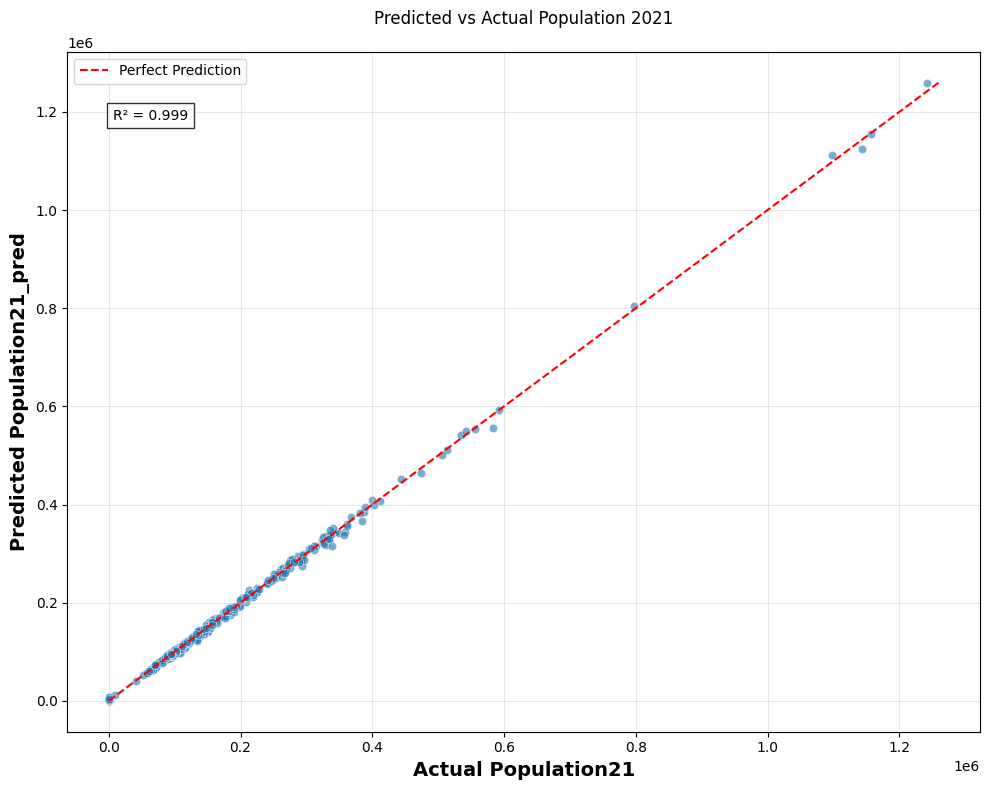

In [103]:
# Population_df2

fig, outliers = plot_scatter(combined_gdf, 'Population21', 'Population21_pred', 
             'LAD24NM', 
             deviation_threshold = 0.0,
             title_str = 'Predicted vs Actual Population 2021', 
             save_path=None)

plt.show()


Outlier Summary:


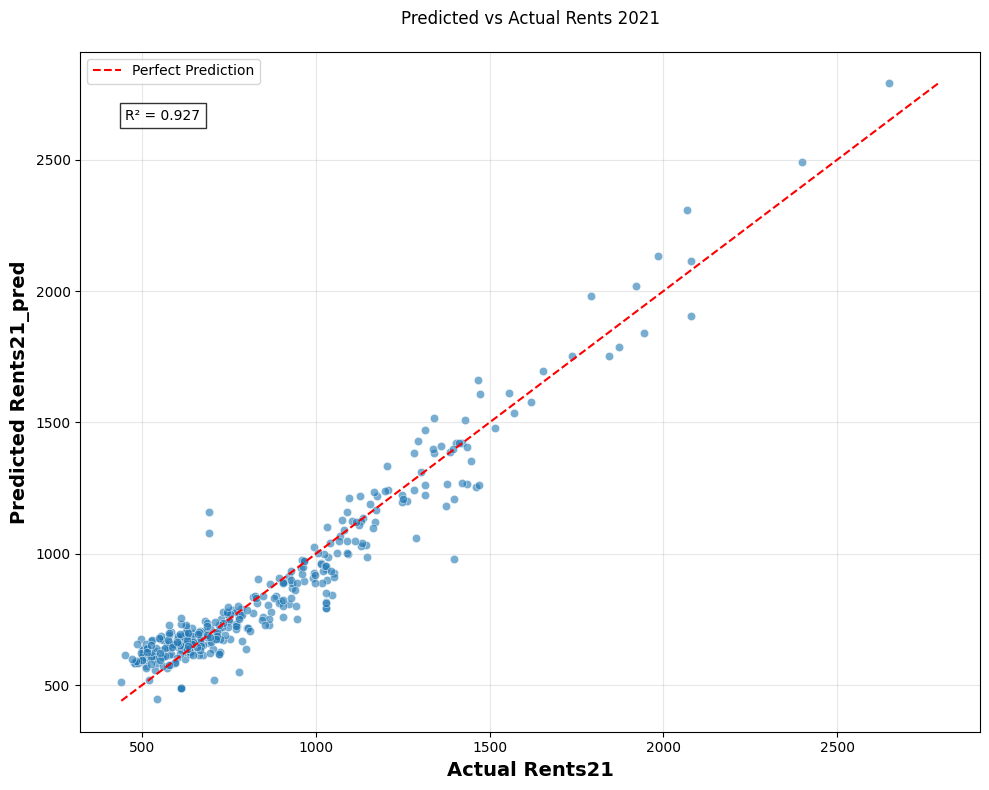

In [104]:
fig, outliers = plot_scatter(combined_gdf, 'Rents21', 'Rents21_pred', 
             'LAD24NM', 
             deviation_threshold = 0.0,
             title_str = 'Predicted vs Actual Rents 2021', 
             save_path=None)

plt.show()

In [105]:

print(combined_gdf.head())


     LAD24CD                                           geometry  \
0  E06000001  MULTIPOLYGON (((-1.22459 54.62418, -1.22457 54...   
1  E06000002  MULTIPOLYGON (((-1.27712 54.54791, -1.27720 54...   
2  E06000003  MULTIPOLYGON (((-1.20098 54.57763, -1.20037 54...   
3  E06000004  MULTIPOLYGON (((-1.27493 54.55187, -1.27546 54...   
4  E06000005  POLYGON ((-1.43836 54.59508, -1.43807 54.59495...   

                LAD24NM     LONG       LAT  Household11  Household21  \
0            hartlepool -1.27017  54.67613      40152.0        42242   
1         middlesbrough -1.21099  54.54467      56755.0        57009   
2  redcar and cleveland -1.00656  54.56752      59264.0        63338   
3      stockton-on-tees -1.30664  54.55687      78801.0        83315   
4            darlington -1.56835  54.53534      46328.0        48475   

   Dwelling11  Dwelling21   Population10  ...     Rents10     Rents21  GPHI11  \
0       42102       44316   93372.887179  ...  404.483930  499.166667   13266   
1 


Outlier Summary:


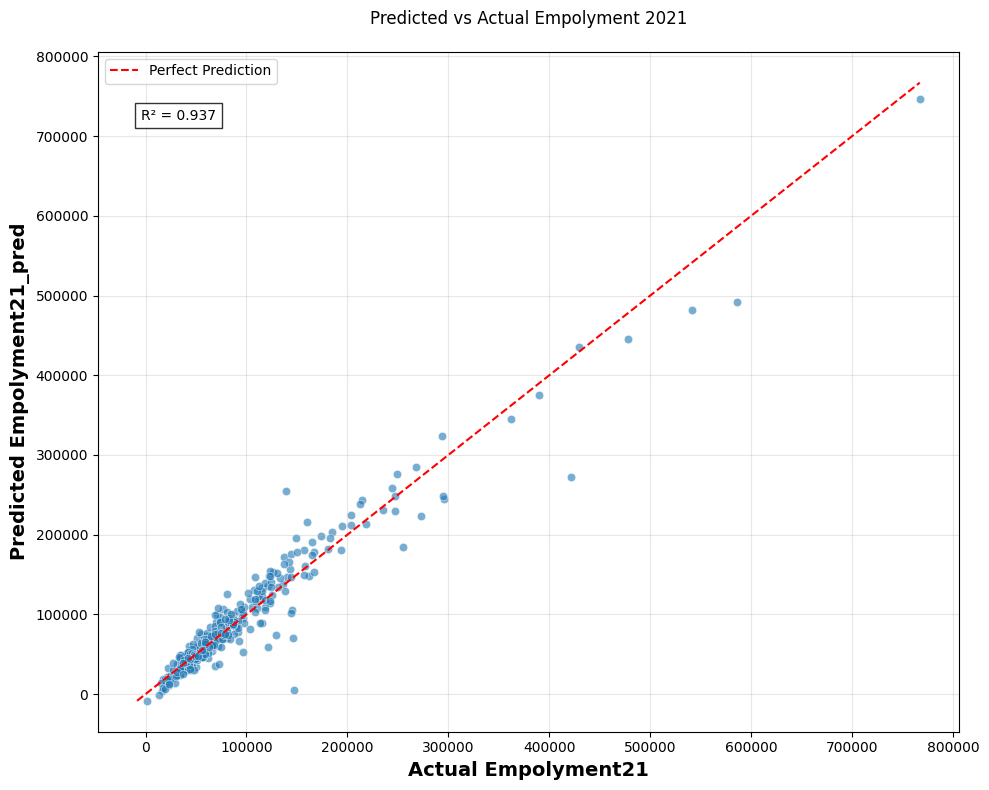

In [106]:
fig, outliers = plot_scatter(combined_gdf, 'Empolyment21', 'Empolyment21_pred', 
             'LAD24NM', 
             deviation_threshold = 0.0,
             title_str = 'Predicted vs Actual Empolyment 2021', 
             save_path=None)

plt.show()

In [40]:
# combined_gdf.to_csv('combined_gdf_gnn.csv', index=False)

## Read ODWP data

In [33]:
flow_data = pd.read_csv('./2011_flow/wu03uk_2011_processed.csv')  # Origin-Destination flows (edges)
#print( flow_data.head() )

In [34]:
nan_rows =  flow_data[  flow_data.isna().any(axis=1)]
nan_rows

,Area of usual residence,Area of workplace,All categories: Method of travel to work,Work mainly at or from home,"Underground, metro, light rail, tram",Train,"Bus, minibus or coach",Taxi,"Motorcycle, scooter or moped",Driving a car or van,Passenger in a car or van,Bicycle,On foot,Other method of travel to work,origin_lon,origin_lat,origin_nm,dest_lon,dest_lat,dest_nm


In [35]:

print(flow_data.columns)


Index(['Area of usual residence', 'Area of workplace',
       'All categories: Method of travel to work',
       'Work mainly at or from home', 'Underground, metro, light rail, tram',
       'Train', 'Bus, minibus or coach', 'Taxi',
       'Motorcycle, scooter or moped', 'Driving a car or van',
       'Passenger in a car or van', 'Bicycle', 'On foot',
       'Other method of travel to work', 'origin_lon', 'origin_lat',
       'origin_nm', 'dest_lon', 'dest_lat', 'dest_nm'],
      dtype='object')


In [36]:
print(flow_data.head())


  Area of usual residence Area of workplace  \
0               E41000001         E41000001   
1               E41000001         E41000002   
2               E41000001         E41000003   
3               E41000001         E41000004   
4               E41000001         E41000005   

   All categories: Method of travel to work  Work mainly at or from home  \
0                                     20777                            0   
1                                      1591                            0   
2                                       534                            0   
3                                      3865                            0   
4                                       433                            0   

   Underground, metro, light rail, tram  Train  Bus, minibus or coach  Taxi  \
0                                     6     26                   1922   527   
1                                     1     32                    140    11   
2                      

In [37]:
flow_data['Walk'] = flow_data['On foot'] + flow_data['Bicycle']
flow_data['Car_Driver'] = flow_data['Driving a car or van'] + flow_data['Motorcycle, scooter or moped']
flow_data['Rail'] = flow_data['Underground, metro, light rail, tram'] + flow_data['Train']
flow_data['Bus'] = flow_data['Bus, minibus or coach'] 
flow_data['WfH'] = flow_data['Work mainly at or from home'] 
flow_data['Other'] = flow_data['Other method of travel to work']
flow_data['Car_Passenger'] = flow_data['Passenger in a car or van'] + flow_data['Taxi']
flow_data['Total'] = flow_data['All categories: Method of travel to work']

In [38]:

flow_data.rename(columns={"Area of usual residence": "origin",
                           "Area of workplace": "destination",
                           "origin_lon": "origin_lon",
                           "origin_lat": "origin_lat",
                           "dest_lon": "dest_lon",
                           "dest_lat": "dest_lat"
                           }, inplace=True)

flow_data2 = flow_data[["origin", "destination", 
                        "On foot", "Bicycle",
                        "Car_Driver", "Rail", 
                        "Bus", "Car_Passenger", "WfH", 
                        "Other", "Total"]]


In [39]:
geojson_path11 =  r'/Users/yuhan/Desktop/a.Cambridge/Census_UK/2.Origin-Destination-Workplace/Flow data/CMLAD_Dec_2011_GCB_GB_2022_275219837489553762.geojson'

CMLAD_gdf11 = gpd.read_file( geojson_path11 )

CMLAD_gdf11['centroid_x'] = CMLAD_gdf11.geometry.centroid.x
CMLAD_gdf11['centroid_y'] = CMLAD_gdf11.geometry.centroid.y

# Inspect the GeoDataFrame
print(CMLAD_gdf11.head())
print(CMLAD_gdf11.shape)
CMLAD11_dict = CMLAD_gdf11.set_index('cmlad11cd').to_dict(orient='index')

   OBJECTID  cmlad11cd             cmlad11nm cmlad11nmw  \
0         1  E41000001            Hartlepool              
1         2  E41000002         Middlesbrough              
2         3  E41000003  Redcar and Cleveland              
3         4  E41000004      Stockton-on-Tees              
4         5  E41000005            Darlington              

                               GlobalID  \
0  d030d336-3850-48de-874e-3cd2baf22b36   
1  610b6098-9a06-4797-b75b-176bea4f75ab   
2  6d8c6fa0-27d7-4117-80c0-0940937517d3   
3  ee1b0a9a-8020-4e41-836a-d7ff8862206c   
4  43d124bc-c0dd-4b84-a6bc-d0648688294b   

                                            geometry  centroid_x  centroid_y  
0  MULTIPOLYGON (((-1.27025 54.72717, -1.26822 54...   -1.259177   54.669386  
1  MULTIPOLYGON (((-1.23003 54.58411, -1.23016 54...   -1.222329   54.542015  
2  MULTIPOLYGON (((-1.13718 54.64695, -1.13875 54...   -1.020677   54.551619  
3  MULTIPOLYGON (((-1.31800 54.64527, -1.31718 54...   -1.332253   54.

/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_61174/2221353404.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  CMLAD_gdf11['centroid_x'] = CMLAD_gdf11.geometry.centroid.x
/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_61174/2221353404.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  CMLAD_gdf11['centroid_y'] = CMLAD_gdf11.geometry.centroid.y


In [40]:
# Replace 'path_to_geojson_file.geojson' with your actual file path
geojson_path21 =  r'/Users/yuhan/Desktop/a.Cambridge/Census_UK/geo/Local_Authority_Districts_May_2024.geojson'

gdf2021 = gpd.read_file( geojson_path21 )
gdf2021['centroid_x'] = gdf2021.geometry.centroid.x
gdf2021['centroid_y'] = gdf2021.geometry.centroid.y

gdf2021['cmlad11nm'] = gdf2021['LAD24NM']
gdf2021['cmlad21nm'] = gdf2021['LAD24NM']


filtered_gdf2021 = gdf2021[
    (gdf2021['LAD24CD'].str.startswith(('S')))
]


gdf2021_EW = gdf2021[
    gdf2021['LAD24CD'].str.startswith(("E", "W")) ] 


# Inspect the GeoDataFrame
print(filtered_gdf2021.tail())

     FID    LAD24CD              LAD24NM LAD24NMW   BNG_E   BNG_N     LONG  \
334  335  S12000045  East Dunbartonshire           261240  676154 -4.22417   
335  336  S12000047                 Fife           339187  704720 -2.98251   
336  337  S12000048    Perth and Kinross           284302  744185 -3.88484   
337  338  S12000049         Glasgow City           261534  667033 -4.21479   
338  339  S12000050    North Lanarkshire           277984  665608 -3.95140   

          LAT                              GlobalID  \
334  55.95829  1fb0a0b5-6bf1-4e48-8fa0-f4b25a06e1ee   
335  56.23111  1e2f0347-e1a7-4835-b5ed-21eeadecfae3   
336  56.57528  024441f0-47cb-4c3e-a1a3-41708ffd39f4   
337  55.87649  6d876f18-43bc-4196-8e24-11f984d1ea3f   
338  55.86814  76d46ff4-4214-4489-872d-66c825bc6a96   

                                              geometry  centroid_x  \
334  POLYGON ((-4.15238 56.00804, -4.15224 56.00699...   -4.225548   
335  MULTIPOLYGON (((-3.30257 56.03094, -3.30251 56...   -3.

/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_61174/1068626102.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf2021['centroid_x'] = gdf2021.geometry.centroid.x
/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_61174/1068626102.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf2021['centroid_y'] = gdf2021.geometry.centroid.y


In [41]:

def join_and_analyze_overlap(gdf1, gdf2, id_column1='id1', id_column2='id2'):
    """
    Join GeoDataFrames based on largest overlapping area
    
    Args:
        gdf1, gdf2: GeoDataFrames to join
        id_column1, id_column2: ID columns for each GeoDataFrame
    """
    # Ensure same CRS
    if gdf1.crs != gdf2.crs:
        gdf2 = gdf2.to_crs(gdf1.crs)
    
    # Calculate intersection
    intersections = gpd.overlay(gdf1, gdf2, how='intersection')
    
    # Calculate areas
    intersections['intersection_area'] = intersections.geometry.area
    
    # Get largest overlap
    largest_overlaps = (intersections.sort_values('intersection_area', ascending=False)
                       .groupby(id_column1).first()
                       .reset_index())
    
    # Visualize results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Original geometries
    gdf1.plot(ax=ax1, alpha=0.5, label='GDF1')
    #gdf2.plot(ax=ax1, alpha=0.5, label='GDF2')
    ax1.set_title('Original Geometries')
    ax1.legend()
    
    # Joined result
    largest_overlaps.plot(
        ax=ax2,
        column='intersection_area',
        legend=True,
        legend_kwds={'label': 'Overlap Area'}
    )
    ax2.set_title('Largest Overlaps')
    
    plt.tight_layout()
    plt.show()
    
    return largest_overlaps


/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_61174/11142698.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersections['intersection_area'] = intersections.geometry.area
/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_61174/11142698.py:31: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax1.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


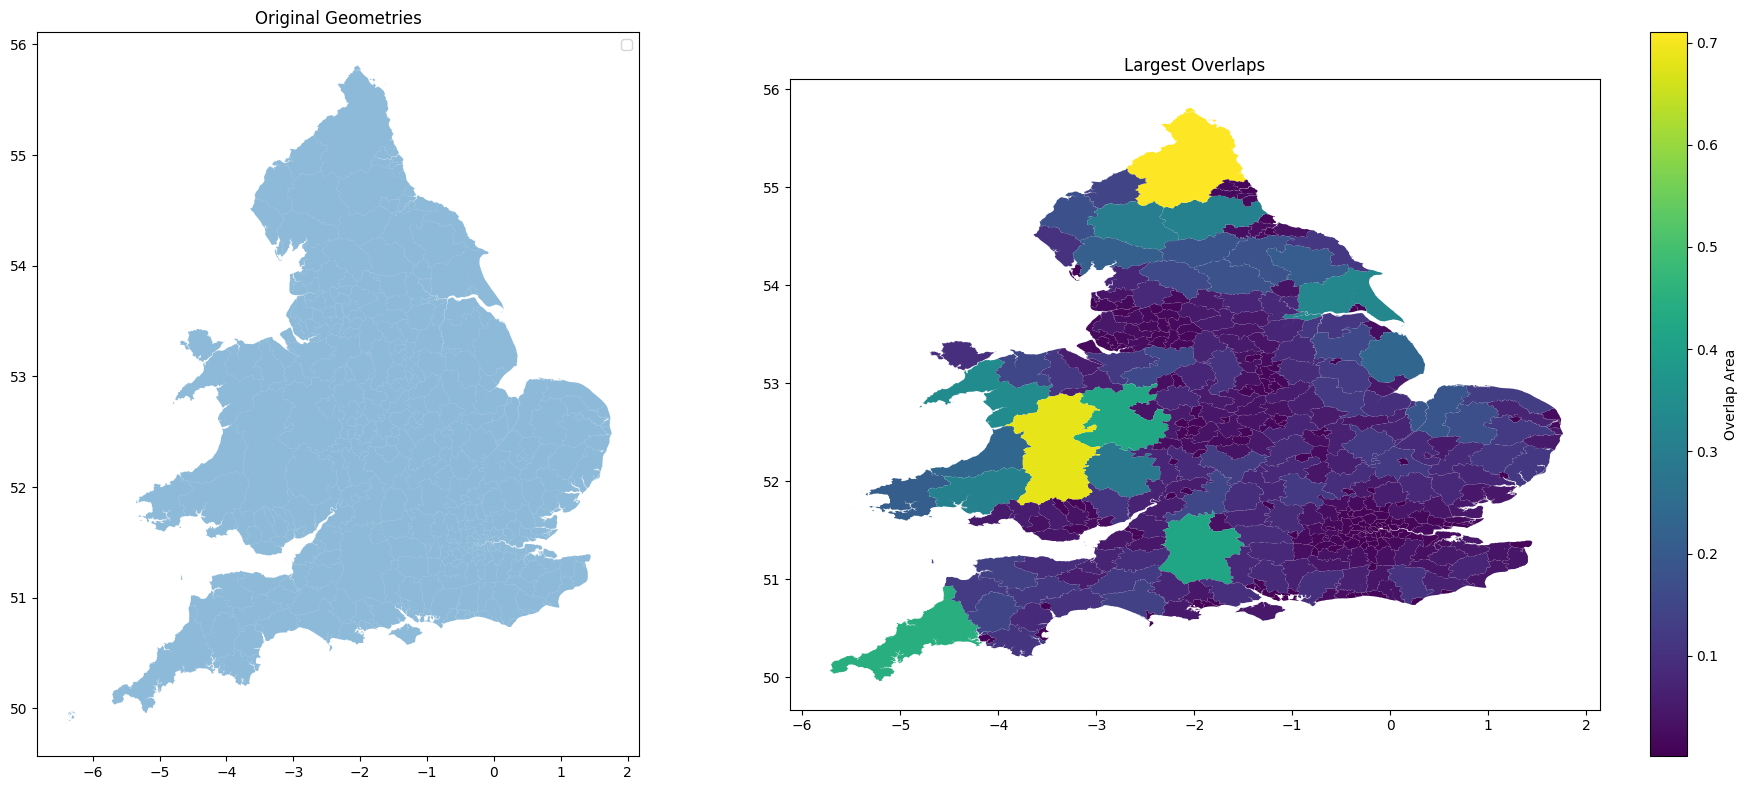

In [42]:

joined_result = join_and_analyze_overlap(
    CMLAD_gdf11,
    gdf2021_EW,
    id_column1='cmlad11cd',
    id_column2='LAD24CD'
)


geo_mapping = dict(zip( joined_result["cmlad11cd"], joined_result["LAD24CD"]))


In [43]:
geo_mapping['E41000001']

'E06000001'

In [44]:
def find_missing_keys(df, column, mapping_dict):
    # Get all unique values from the column
    unique_values = set(df[column].unique())
    # Get all keys from the dictionary
    dict_keys = set(mapping_dict.keys())
    # Find missing keys
    missing_keys = unique_values - dict_keys
    
    print(f"Found {len(missing_keys)} missing keys:")
    print(missing_keys)
    return missing_keys

missing_keys = find_missing_keys(flow_data2, 'origin', geo_mapping)


Found 32 missing keys:
{'S12000010', 'S12000042', 'S12000013', 'S12000023', 'S12000030', 'S12000026', 'S12000047', 'S12000038', 'S12000020', 'S12000019', 'S12000008', 'S12000014', 'S12000021', 'S12000011', 'S12000005', 'S12000045', 'S12000029', 'S12000018', 'S12000033', 'S12000050', 'S12000017', 'S12000036', 'S12000028', 'S12000034', 'S12000049', 'S12000006', 'S12000035', 'S12000041', 'S12000040', 'S12000039', 'S12000048', 'S12000027'}


In [45]:
missing_keys = find_missing_keys(flow_data2, 'destination', geo_mapping)


Found 32 missing keys:
{'S12000010', 'S12000042', 'S12000013', 'S12000023', 'S12000030', 'S12000026', 'S12000047', 'S12000038', 'S12000020', 'S12000019', 'S12000008', 'S12000014', 'S12000021', 'S12000011', 'S12000005', 'S12000045', 'S12000029', 'S12000033', 'S12000018', 'S12000050', 'S12000017', 'S12000036', 'S12000028', 'S12000034', 'S12000049', 'S12000006', 'S12000035', 'S12000041', 'S12000040', 'S12000039', 'S12000048', 'S12000027'}


In [46]:
flow_data2['origin'] = flow_data2['origin'].map(geo_mapping).fillna( flow_data2['origin'])

flow_data2['destination'] = flow_data2['destination'].map( geo_mapping ).fillna( flow_data2['destination'])


/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_61174/1613402087.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flow_data2['origin'] = flow_data2['origin'].map(geo_mapping).fillna( flow_data2['origin'])
/var/folders/t6/8gnslc_j433220_1kgd9hv_c0000gn/T/ipykernel_61174/1613402087.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flow_data2['destination'] = flow_data2['destination'].map( geo_mapping ).fillna( flow_data2['destination'])


In [47]:
flow_data2.head()

,origin,destination,On foot,Bicycle,Car_Driver,Rail,Bus,Car_Passenger,WfH,Other,Total
0,E06000001,E06000001,3789,593,11895,32,1922,2492,0,54,20777
1,E06000001,E06000002,60,13,1231,33,140,110,0,4,1591
2,E06000001,E06000003,16,1,454,0,21,40,0,2,534
3,E06000001,E06000004,60,29,3167,50,167,385,0,7,3865
4,E06000001,E06000005,15,2,364,11,7,34,0,0,433


In [48]:
nan_rows =  flow_data2[ flow_data2.isna().any(axis=1)]
nan_rows

,origin,destination,On foot,Bicycle,Car_Driver,Rail,Bus,Car_Passenger,WfH,Other,Total


In [49]:
origin_list = flow_data2.origin.unique().tolist()
destination_list = flow_data2.destination.unique().tolist()
print(len(origin_list))
print(len(destination_list))
print(len(gdf2021) )

#destination_list.pop(2)
print(len(destination_list))


348
348
361
348


In [50]:
def check_values_exist(df, column, value_list):
    # Check if all values exist
    column_set = set(df[column].unique())
    value_set = set(value_list)
    
    # Check if all values exist
    missing = column_set - value_set 
    exists = len(missing) == 0
    
    print(f"All values exist: {exists}")
    if not exists:
        print(f"Missing values: {missing}")
    
    return exists, missing

orig_exists, orig_missing = check_values_exist(gdf2021, 'LAD24CD', origin_list)
dest_exists, dest_missing = check_values_exist(gdf2021, 'LAD24CD', destination_list)


All values exist: False
Missing values: {'N09000003', 'N09000006', 'N09000008', 'N09000004', 'N09000005', 'N09000011', 'E09000001', 'N09000009', 'N09000010', 'N09000001', 'E06000053', 'N09000002', 'N09000007'}
All values exist: False
Missing values: {'N09000003', 'N09000006', 'N09000008', 'N09000004', 'N09000005', 'N09000011', 'E09000001', 'N09000009', 'N09000010', 'N09000001', 'E06000053', 'N09000002', 'N09000007'}


In [51]:
flow_time_df = pd.read_csv("./od_matrix_driving.csv")  # Origin-Destination flows (edges)

flow_time_df.columns = [str(col) for col in flow_time_df.columns]
flow_time_df.drop(columns = ["Unnamed: 0"], inplace = True)
flow_time_df.head()

,origin_code,origin_long,origin_lat,workplace_code,workplace_long,workplace_lat,distance_km,log_orig_pop,log_dest_pop,log_distance,pred_flow,distance_meters,duration_seconds,duration_in_traffic
0,E06000001,-1.27017,54.67613,E06000001,-1.27017,54.67613,0.000000,11.447768,11.447768,-2.302585,1.144517e+06,0.0,0.0,0.0
1,E06000001,-1.27017,54.67613,E06000002,-1.21099,54.54467,15.124974,11.447768,11.848647,2.722937,1.683196e+02,26902.0,1369.0,1462.0
2,E06000001,-1.27017,54.67613,E06000003,-1.00656,54.56752,20.883362,11.447768,11.846257,3.043730,9.474489e+01,41816.0,1939.0,2049.0
3,E06000001,-1.27017,54.67613,E06000004,-1.30664,54.55687,13.483049,11.447768,12.204832,2.608823,2.385960e+02,19642.0,1066.0,1153.0
4,E06000001,-1.27017,54.67613,E06000005,-1.56835,54.53534,24.837240,11.447768,11.581584,3.216362,6.247934e+01,37449.0,1966.0,2005.0


In [52]:
flow_data2.head()

,origin,destination,On foot,Bicycle,Car_Driver,Rail,Bus,Car_Passenger,WfH,Other,Total
0,E06000001,E06000001,3789,593,11895,32,1922,2492,0,54,20777
1,E06000001,E06000002,60,13,1231,33,140,110,0,4,1591
2,E06000001,E06000003,16,1,454,0,21,40,0,2,534
3,E06000001,E06000004,60,29,3167,50,167,385,0,7,3865
4,E06000001,E06000005,15,2,364,11,7,34,0,0,433


In [53]:
flow_data2 = pd.merge( flow_data2, flow_time_df, 
                       left_on  = ["origin", "destination"], 
                       right_on = ["origin_code", "workplace_code"],
                       how = "left" )
flow_data2.head()

,origin,destination,On foot,Bicycle,Car_Driver,Rail,Bus,Car_Passenger,WfH,Other,...,workplace_long,workplace_lat,distance_km,log_orig_pop,log_dest_pop,log_distance,pred_flow,distance_meters,duration_seconds,duration_in_traffic
0,E06000001,E06000001,3789,593,11895,32,1922,2492,0,54,...,-1.27017,54.67613,0.000000,11.447768,11.447768,-2.302585,1.144517e+06,0.0,0.0,0.0
1,E06000001,E06000002,60,13,1231,33,140,110,0,4,...,-1.21099,54.54467,15.124974,11.447768,11.848647,2.722937,1.683196e+02,26902.0,1369.0,1462.0
2,E06000001,E06000003,16,1,454,0,21,40,0,2,...,-1.00656,54.56752,20.883362,11.447768,11.846257,3.043730,9.474489e+01,41816.0,1939.0,2049.0
3,E06000001,E06000004,60,29,3167,50,167,385,0,7,...,-1.30664,54.55687,13.483049,11.447768,12.204832,2.608823,2.385960e+02,19642.0,1066.0,1153.0
4,E06000001,E06000005,15,2,364,11,7,34,0,0,...,-1.56835,54.53534,24.837240,11.447768,11.581584,3.216362,6.247934e+01,37449.0,1966.0,2005.0


In [54]:
flow_data2.to_csv('./OD_flow_2011_travel_time2.csv', index=False)
